<a href="https://colab.research.google.com/github/ArtyomIT/Dog-Breed-Identification/blob/main/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Update keras version

In [ ]:
import keras
print(keras.__version__)

3.0.0


In [ ]:
!pip install --upgrade keras==3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


### Importing libraries

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0
import random

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

### Loading and unpacking dataset

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-05-30 09:47:14--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  19.1MB/s    in 41s     

2024-05-30 09:47:57 (17.9 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
!unzip -qo "stanford_dogs" -d ./dataset
IMAGE_PATH = './dataset/'

### Filter damaged images

In [ ]:
num_skipped = 0
for folder_name in os.listdir(IMAGE_PATH):
    folder_path = os.path.join(IMAGE_PATH, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


### Filter of class count

In [ ]:
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

CLASS_COUNT = len(CLASS_LIST)

print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

In [ ]:
selected_classes = random.sample(CLASS_LIST, 10)

In [ ]:
import shutil
for folder_name in os.listdir(IMAGE_PATH):
    folder_path = os.path.join(IMAGE_PATH, folder_name)
    if folder_name not in selected_classes:
        shutil.rmtree(folder_path)

In [ ]:
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

CLASS_COUNT = len(CLASS_LIST)

print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 10
Метки классов: ['Airedale', 'Bernese_mountain_dog', 'English_foxhound', 'Irish_water_spaniel', 'Malinois', 'Miniature_poodle', 'Norwich_terrier', 'Samoyed', 'Scotch_terrier', 'Standard_schnauzer']


### Generating a dataset

In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="both",
    seed=42,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1744 files belonging to 10 classes.
Using 1396 files for training.
Using 348 files for validation.


### Data Augmentation

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

### Data preprocessing

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Supporting functions

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

### Transferring training from pre-trained scales

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

### Model training

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - acc: 0.6402 - loss: 1.2603 - val_acc: 0.9713 - val_loss: 0.1331
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.9095 - loss: 0.3830 - val_acc: 0.9828 - val_loss: 0.0712
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9262 - loss: 0.2974 - val_acc: 0.9741 - val_loss: 0.0712
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9480 - loss: 0.2134 - val_acc: 0.9713 - val_loss: 0.0759
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - acc: 0.9118 - loss: 0.3299 - val_acc: 0.9856 - val_loss: 0.0675
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - acc: 0.9550 - loss: 0.2013 - val_acc: 0.9770 - val_loss: 0.0845
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9445 - loss: 0.2227 - val_acc: 0.9856 - val_loss: 0.0738
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.9481 - loss: 0.1945 - val_acc: 0.9741 - val_loss: 0.0797
Epoch 9/20
11/11 ━━━

### Accuracy and loss graphs

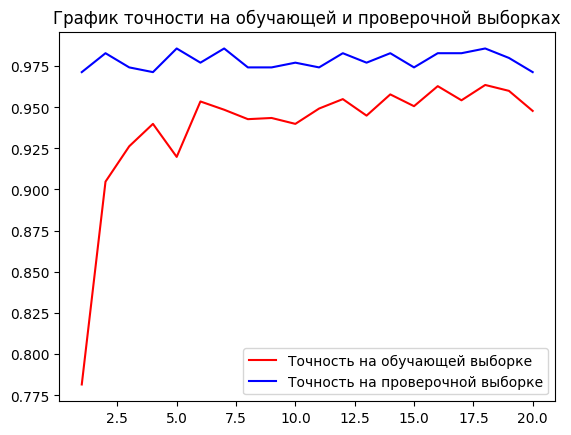

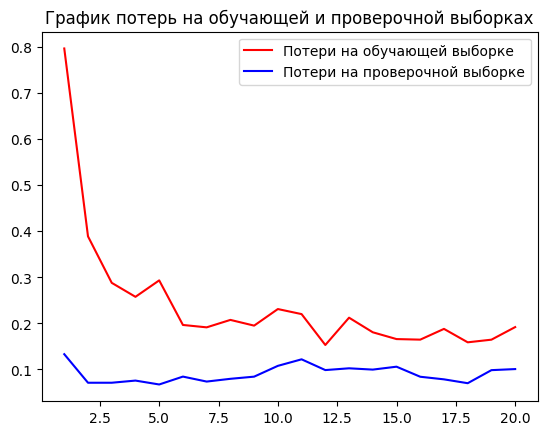

In [ ]:
show_plot(history)

### Test

--2024-05-30 10:30:49--  https://storage.yandexcloud.net/bucket-picture/fox_xound.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198913 (194K) [image/jpeg]
Saving to: ‘fox_xound.jpeg.1’

fox_xound.jpeg.1    100%[===================>] 194.25K   242KB/s    in 0.8s    

2024-05-30 10:30:51 (242 KB/s) - ‘fox_xound.jpeg.1’ saved [198913/198913]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


(-0.5, 223.5, 223.5, -0.5)

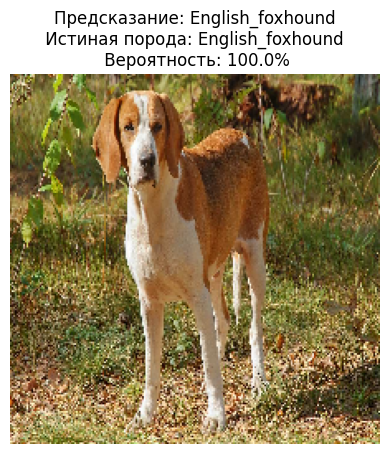

In [ ]:
# To check, change the image according to the classes in your dataset
!wget https://storage.yandexcloud.net/bucket-picture/fox_xound.jpeg
TEST_IMG='./fox_xound.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
plt.imshow(img)


img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: English_foxhound \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  )
plt.axis("off")